<a href="https://colab.research.google.com/github/Raghad-Odwan/DermAI_Training/blob/main/DermAI_Cross_validaition_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DermAI Dataset**

Palestine Technical University - Kadoorie
    
Department of Computer Systems Engineering

DermAI: Intelligent Skin Cancer Detection Using Convolutional 
Neural Network & Transfer Learning Architectures                           




---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
%%javascript
function ClickConnect(){
    console.log("Preventing Colab timeout");
    document.querySelector("colab-toolbar-button#connect").click();
}
setInterval(ClickConnect, 60000)

<IPython.core.display.Javascript object>



---



## **About this notebook**

This notebook has been prepared for the preparation and training of a machine learning model specialized in skin cancer detection.
The model performs binary classification of skin lesion images into two categories: Benign and Malignant.


### **Dataset Source**

The dataset used in this project was collected from the following sources:


*   **ISIC Archive**
*   **Kaggle**



The dataset contains approximately **13,294** benign and **6,211** malignant images, providing a total of around **19,505** samples used for training, validation, and testing.


## **Dataset Preparation & Preprocessing**

In [ ]:
# Import required libraries
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from collections import defaultdict
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define main dataset path
base_dir = "/content/drive/MyDrive/Dataset/Dataset"
folders = ["benign", "malignant"]

print("Base directory:", base_dir)
for folder in folders:
    path = os.path.join(base_dir, folder)
    print(f"{folder}: {len(os.listdir(path))} files")

Base directory: /content/drive/MyDrive/Dataset/Dataset
benign: 13291 files
malignant: 6210 files


In [ ]:
# Create a folder for problematic images
dup_dir = os.path.join(base_dir, "duplicates_or_corrupted")
os.makedirs(dup_dir, exist_ok=True)
print("Duplicate/Corrupted folder created at:", dup_dir)

Duplicate/Corrupted folder created at: /content/drive/MyDrive/Dataset/Dataset/duplicates_or_corrupted


In [ ]:
# Define an image cleaning class
class ImageCleaner:
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.folders_to_check = ['benign', 'malignant']
        self.problem_folder = self.base_path / 'duplicates_or_corrupted'
        self.problem_folder.mkdir(exist_ok=True)
        self.stats = {'total_checked': 0, 'corrupted': 0, 'duplicates': 0, 'low_quality': 0, 'healthy': 0}
        self.image_hashes = defaultdict(list)

    def calculate_hash(self, image_path):
        import hashlib
        try:
            hasher = hashlib.md5()
            with open(image_path, 'rb') as f:
                buf = f.read()
                hasher.update(buf)
            return hasher.hexdigest()
        except:
            return None

    def is_image_corrupted(self, image_path):
        try:
            with Image.open(image_path) as img:
                img.verify()
            return False
        except:
            return True

    def check_image_quality(self, image_path, min_width=50, min_height=50):
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                if width < min_width or height < min_height:
                    return False
                if os.path.getsize(image_path) < 1000:
                    return False
            return True
        except:
            return False

    def move_to_problem_folder(self, image_path):
        try:
            dest_subfolder = self.problem_folder / image_path.parent.name
            dest_subfolder.mkdir(exist_ok=True)
            shutil.move(str(image_path), str(dest_subfolder / image_path.name))
        except Exception as e:
            print(f"Error moving {image_path.name}: {e}")

    def clean_folder(self, folder_name):
        folder_path = self.base_path / folder_name
        image_exts = ['.jpg', '.jpeg', '.png']
        images = [f for f in folder_path.iterdir() if f.suffix.lower() in image_exts]
        print(f"Cleaning {folder_name} ({len(images)} images)...")

        for img_path in tqdm(images, desc=f"Checking {folder_name}"):
            self.stats['total_checked'] += 1
            if self.is_image_corrupted(img_path):
                self.move_to_problem_folder(img_path)
                self.stats['corrupted'] += 1
                continue
            if not self.check_image_quality(img_path):
                self.move_to_problem_folder(img_path)
                self.stats['low_quality'] += 1
                continue
            img_hash = self.calculate_hash(img_path)
            if img_hash in self.image_hashes:
                self.move_to_problem_folder(img_path)
                self.stats['duplicates'] += 1
            else:
                self.image_hashes[img_hash].append(str(img_path))
                self.stats['healthy'] += 1

    def clean_all(self):
        for folder in self.folders_to_check:
            self.clean_folder(folder)
        print("\nCleaning Summary:")
        for k, v in self.stats.items():
            print(f"{k}: {v}")

# Run the cleaning process
cleaner = ImageCleaner(base_dir)
cleaner.clean_all()

Cleaning benign (13291 images)...


Checking benign: 100%|██████████| 13291/13291 [04:38<00:00, 47.76it/s] 


Cleaning malignant (6210 images)...


Checking malignant: 100%|██████████| 6210/6210 [02:16<00:00, 45.48it/s] 


Cleaning Summary:
total_checked: 19501
corrupted: 0
duplicates: 0
low_quality: 0
healthy: 19501


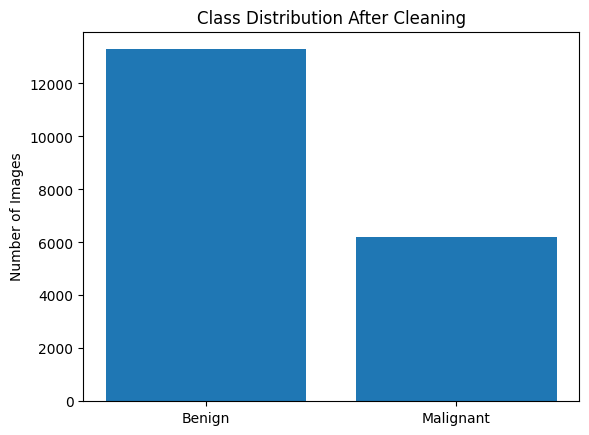

In [ ]:
# Visualize class distribution
count_benign = len(os.listdir(os.path.join(base_dir, "benign")))
count_malignant = len(os.listdir(os.path.join(base_dir, "malignant")))
plt.bar(["Benign", "Malignant"], [count_benign, count_malignant])
plt.title("Class Distribution After Cleaning")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
# Resize all images to (224x224)
IMG_SIZE = (224, 224)
for cat in folders:
    src_dir = os.path.join(base_dir, cat)
    files = os.listdir(src_dir)
    for fname in tqdm(files, desc=f"Resizing {cat}"):
        path = os.path.join(src_dir, fname)
        try:
            img = cv2.imread(path)
            if img is None: continue
            resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
            cv2.imwrite(path, resized)
        except:
            continue

Resizing malignant: 100%|██████████| 6210/6210 [02:03<00:00, 50.19it/s]


In [ ]:
# Split dataset (70% train, 15% val, 15% test)
split_dir = "/content/ai/Dataset_split"
os.makedirs(split_dir, exist_ok=True)

rows = []
for label in folders:
    path = os.path.join(base_dir, label)
    for fname in os.listdir(path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            rows.append({'path': os.path.join(path, fname), 'label': label})

df = pd.DataFrame(rows)
train_temp, test = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train, val = train_test_split(train_temp, test_size=0.1765, stratify=train_temp['label'], random_state=42)

for subset in ['train', 'val', 'test']:
    for label in folders:
        os.makedirs(os.path.join(split_dir, subset, label), exist_ok=True)

def copy_images(df_subset, subset_name):
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc=f"Copying {subset_name}"):
        dest = os.path.join(split_dir, subset_name, row['label'], os.path.basename(row['path']))
        shutil.copy2(row['path'], dest)

copy_images(train, "train")
copy_images(val, "val")
copy_images(test, "test")

print(f"\nDataset split completed successfully!")
print(f"Train: {len(train)} | Val: {len(val)} | Test: {len(test)}")

Copying test: 100%|██████████| 2926/2926 [00:10<00:00, 266.10it/s]


Dataset split completed successfully!
Train: 13649 | Val: 2926 | Test: 2926




---

####  Build DataFrame & Quick Integrity Check

In [ ]:
# Count the number of image files in each class folder (benign and malignant)
# This function walks through all subdirectories and counts only valid image files.
import os, sys, traceback
base_path = "/content/drive/MyDrive/Dataset/Dataset"

def count_images_in_folder(folder):
    exts = ('.jpg','.jpeg','.png','.bmp')
    cnt = 0
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(exts):
                cnt += 1
    return cnt

for cls in ['benign','malignant']:
    p = os.path.join(base_path, cls)
    if not os.path.exists(p):
        print(f" WARNING: folder not found: {p}")
    else:
        print(f"{cls}: {count_images_in_folder(p):,} images")

benign: 13,291 images
malignant: 6,210 images


In [ ]:
import os
import pandas as pd
from PIL import Image
import random
# build dataframe (paths + labels)
rows=[]
exts = ('.jpg','.jpeg','.png','.bmp')
for cls in ['benign','malignant']:
    folder = os.path.join(base_path, cls)
    if not os.path.exists(folder):
        continue
    for root, dirs, files in os.walk(folder):
        for fname in files:
            if fname.lower().endswith(exts):
                rows.append({'path': os.path.join(root, fname), 'label': cls})

df = pd.DataFrame(rows)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['label_idx'] = df['label'].map({'benign':0, 'malignant':1})
print("Total samples:", len(df))
print(df['label'].value_counts())

Total samples: 19501
label
benign       13291
malignant     6210
Name: count, dtype: int64


In [ ]:
#  quick corrupted-files check (lightweight, may take time if dataset big)
#  try to open the first N images from each class to detect obvious corruption
from PIL import Image
import random

def check_samples(df, n_per_class=20):
    corrupted = []
    for cls in df['label'].unique():
        paths = df[df['label']==cls]['path'].tolist()
        sample_paths = random.sample(paths, min(n_per_class, len(paths)))
        for p in sample_paths:
            try:
                img = Image.open(p)
                img.verify()
            except Exception as e:
                corrupted.append((p, str(e)))
    return corrupted

corrupted_examples = check_samples(df, n_per_class=30)
if corrupted_examples:
    print(" Found corrupted or unreadable sample(s):", len(corrupted_examples))
    for p,err in corrupted_examples[:5]:
        print("-", p, "=>", err)
else:
    print(" Quick corrupted-sample check passed successfully (no issues in sampled files).")

 Quick corrupted-sample check passed successfully (no issues in sampled files).


In [ ]:
# Save metadata CSV
out_csv = "/content/drive/MyDrive/ai/data/df_metadata.csv"
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df.to_csv(out_csv, index=False)
print(" Metadata saved to:", out_csv)

 Metadata saved to: /content/drive/MyDrive/ai/data/df_metadata.csv


In [ ]:
display(df.head(10))
print("\nCounts (sanity):")
print(df['label'].value_counts())

,path,label,label_idx
0,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
1,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
2,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
3,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
4,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
5,/content/drive/MyDrive/Dataset/Dataset/maligna...,malignant,1
6,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
7,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
8,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0
9,/content/drive/MyDrive/Dataset/Dataset/benign/...,benign,0



Counts (sanity):
label
benign       13291
malignant     6210
Name: count, dtype: int64


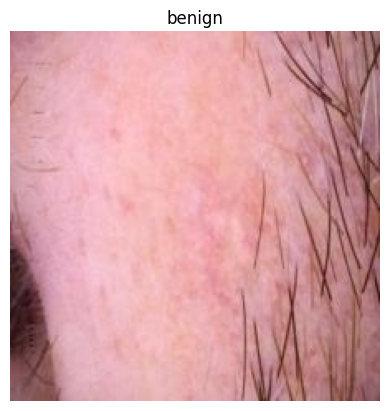

In [ ]:
# Quick test reading data
# Randomly load and display one sample image from the dataset
# to verify that image paths are correct and preprocessing worked properly.
from tensorflow.keras.preprocessing import image
import numpy as np
import random
import matplotlib.pyplot as plt

sample = random.choice(df['path'].tolist())
img = image.load_img(sample, target_size=(224,224))
plt.imshow(img)
plt.axis('off')
plt.title(sample.split('/')[-2])
plt.show()



---

